Copyright (C) 2025 Advanced Micro Devices, Inc. All rights reserved.
Portions of this notebook consist of AI-generated content.

Permission is hereby granted, free of charge, to any person obtaining a copy

of this software and associated documentation files (the "Software"), to deal

in the Software without restriction, including without limitation the rights

to use, copy, modify, merge, publish, distribute, sublicense, and/or sell

copies of the Software, and to permit persons to whom the Software is

furnished to do so, subject to the following conditions:



The above copyright notice and this permission notice shall be included in all

copies or substantial portions of the Software.



THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR

IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,

FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE

AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER

LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,

OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE

SOFTWARE.

# CV05 Segment Anything (SAM)

### Lab Description

This laboratory exercise introduces the **Segment Anything Model (SAM)**, a state-of-the-art foundation model for image segmentation developed by Meta AI. Unlike traditional segmentation models trained on a specific dataset, SAM can generalize to diverse images and tasks with minimal additional supervision. It can perform **automatic segmentation** as well as **prompt-based segmentation** using points, boxes, or masks.

In this hands-on lab, you will run inference with a pre-trained SAM checkpoint on your own images. You will measure inference efficiency, visualize segmentation results as overlays and colored segmentation maps, and analyze the trade-off between accuracy, mask count, and computational cost.

### What you can expect to learn

- **Theoretical Understanding**: Understand the concept of foundation models for segmentation, SAM’s architecture (ViT backbone + mask decoder), and the difference between automatic and prompt-based segmentation modes.  
- **Implementation of SAM Inference**: Learn how to load a pre-trained SAM model, set up input images, and generate segmentation masks.  
- **Training & Monitoring** (Inference in this case): Track per-image inference time, batch size, and VRAM usage, while recording the number of masks generated.  
- **Visualization & Evaluation**:  
  - Generate overlay images with masks drawn on top of the input.  
  - Create distinct-colored segmentation maps for clear visualization.  
  - Save per-image logs and a CSV summary of inference performance.  


In [ ]:
import os
import sys

import torch
import torchvision

print("Python:", sys.version.split()[0])
print("PyTorch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

已設定使用 GPU 4，之後的 torch 只會看到這一張卡
Python: 3.10.18
PyTorch: 2.8.0+rocm6.4
Torchvision: 0.23.0+rocm6.4
CUDA available: True
CUDA device: AMD Radeon AI PRO R9700


## 1. Install Dependencies (SAM)
We install the official Segment Anything package from source.  
> Note: This only installs **code**. **Model weights are NOT downloaded** here (see the next step).

In [2]:
!pip -q install opencv-python pycocotools
!pip -q install git+https://github.com/facebookresearch/segment-anything.git

  DEPRECATION: Building 'segment_anything' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'segment_anything'. Discussion can be found at https://github.com/pypa/pip/issues/6334


## 2. Imports, Config, and Paths
- Define a simple config `CFG` for inference.  
- Create **DATA_DIR** and **OUTPUT_DIR** using `os.path.expanduser("~/data")`.  
- You will upload:
  - a SAM checkpoint into `~/data/sam_checkpoints/` (e.g., `sam_vit_b.pth`)
  - your test images into `~/data/sam_inputs/`


In [3]:
import glob
import time
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry


@dataclass
class CFG:
    seed: int = 42
    # Choose one of: 'vit_h', 'vit_l', 'vit_b'
    sam_variant: str = "vit_b"
    # File name you upload under ~/data/sam_checkpoints/
    sam_ckpt_name: str = "sam_vit_b.pth"
    img_size_limit: int = 2048  # Max longer side before resizing for speed
    prompt_mode: str = "auto"  # 'auto' or 'points' (prompt-based)
    batch_size: int = 8  # Only for prompt batches when using 'points'
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


cfg = CFG()

# Base paths (always under ~/data)
DATA_DIR = os.path.expanduser("~/data")
CKPT_DIR = os.path.join(DATA_DIR, "sam_checkpoints")
INPUT_DIR = os.path.join(DATA_DIR, "sam_inputs")
OUTPUT_DIR = os.path.join(DATA_DIR, "sam_outputs")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(INPUT_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("DATA_DIR:", DATA_DIR)
print("CKPT_DIR:", CKPT_DIR)
print("INPUT_DIR:", INPUT_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)


def set_seed(seed=42):
    import random

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed(cfg.seed)
cfg

DATA_DIR: /home/aup/data
CKPT_DIR: /home/aup/data/sam_checkpoints
INPUT_DIR: /home/aup/data/sam_inputs
OUTPUT_DIR: /home/aup/data/sam_outputs


CFG(seed=42, sam_variant='vit_b', sam_ckpt_name='sam_vit_b.pth', img_size_limit=2048, prompt_mode='auto', batch_size=8, device='cuda')

## 3. Upload Check: Weights & Images
  
1. Download a SAM checkpoint from the official repository (link: https://github.com/facebookresearch/segment-anything?tab=readme-ov-file), e.g. **ViT-B** (`sam_vit_b.pth`).  
2. Upload it to: `~/data/sam_checkpoints/`  
3. Upload some test images (JPG/PNG) to: `~/data/sam_inputs/`

Run the cell to verify files exist.


In [8]:
ckpt_path = os.path.join(CKPT_DIR, cfg.sam_ckpt_name)
assert os.path.exists(ckpt_path), f"❗ Missing checkpoint: {ckpt_path}\nPlease upload a SAM .pth checkpoint."

input_images = sorted(glob.glob(os.path.join(INPUT_DIR, "*.*")))
assert len(input_images) > 0, f"❗ No images found in {INPUT_DIR}\nPlease upload some .jpg/.png images."

print("Found checkpoint:", ckpt_path)
print("Found input images:", len(input_images))
print("Examples:", input_images[:5])

Found checkpoint: /home/aup/data/sam_checkpoints/sam_vit_b.pth
Found input images: 1
Examples: ['/home/aup/data/sam_inputs/dog.jpg']


## 4. Load SAM Model
We build a SAM model by variant and move it to the configured device.


In [9]:
sam = sam_model_registry[cfg.sam_variant](checkpoint=ckpt_path)
sam.to(device=cfg.device)
print(f"SAM ({cfg.sam_variant}) loaded on {cfg.device}")

SAM (vit_b) loaded on cuda


## 5. Utilities
- Resize images if longer side exceeds `img_size_limit` (to control latency/memory).  
- Track **peak VRAM**.  
- Helper to overlay masks on images and export both **overlay** and **binary mask PNGs**.


In [10]:
import cv2


def gpu_reset_peaks():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()


def read_image_rgb(path):
    img = Image.open(path).convert("RGB")
    return np.array(img)


def maybe_resize(img: np.ndarray, limit: int) -> np.ndarray:
    h, w = img.shape[:2]
    if max(h, w) <= limit:
        return img
    if h >= w:
        new_h = limit
        new_w = int(w * (limit / h))
    else:
        new_w = limit
        new_h = int(h * (limit / w))
    return cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)


def draw_mask_overlay(image: np.ndarray, masks: list[dict]) -> np.ndarray:
    """Overlay semi-transparent masks on image."""
    out = image.copy()
    for m in masks:
        mask = m["segmentation"].astype(bool)
        # Random alpha; deterministic with seed
        color = np.random.default_rng(123).integers(0, 255, size=3, dtype=np.uint8)
        out[mask] = (0.6 * color + 0.4 * out[mask]).astype(np.uint8)
    return out


def save_masks(image_name: str, image: np.ndarray, masks: list[dict], out_dir: str):
    """Save overlay and per-mask PNGs."""
    base = os.path.splitext(os.path.basename(image_name))[0]
    overlay = draw_mask_overlay(image, masks)

    overlay_p = os.path.join(out_dir, f"{base}_overlay.png")
    Image.fromarray(overlay).save(overlay_p)

    # save raw mask stack as individual PNGs
    for i, m in enumerate(masks):
        mask = m["segmentation"].astype(np.uint8) * 255
        mask_p = os.path.join(out_dir, f"{base}_mask_{i:03d}.png")
        Image.fromarray(mask).save(mask_p)

    return overlay_p


def masks_to_colormap(image: np.ndarray, masks: list[dict]) -> np.ndarray:
    """
    Convert list of SAM masks into a single RGB segmentation map,
    where each mask region has a unique color.
    """
    h, w = image.shape[:2]
    seg_map = np.zeros((h, w, 3), dtype=np.uint8)

    rng = np.random.default_rng(42)  # fixed seed for reproducibility
    colors = rng.integers(0, 255, size=(len(masks), 3), dtype=np.uint8)

    for i, m in enumerate(masks):
        mask = m["segmentation"].astype(bool)
        seg_map[mask] = colors[i]

    return seg_map

## 6. Inference Modes
We provide two inference modes:

- **Auto mode**: `SamAutomaticMaskGenerator` produces a set of masks per image automatically.  
- **Points mode**: `SamPredictor` with a few pre-defined point prompts (demo).

> For this lab, default is `auto`. You can switch `cfg.prompt_mode` to `"points"` to test prompt-based inference.


In [11]:
def auto_masks_for_image(sam_model, image_rgb: np.ndarray) -> list[dict]:
    mask_generator = SamAutomaticMaskGenerator(
        model=sam_model,
        points_per_side=32,  # speed/quality trade-off (adjust for your GPU)
        pred_iou_thresh=0.86,
        stability_score_thresh=0.92,
        crop_n_layers=1,
        crop_n_points_downscale_factor=2,
        min_mask_region_area=100,  # remove small regions
    )
    return mask_generator.generate(image_rgb)


def point_prompt_masks(sam_model, image_rgb: np.ndarray) -> list[dict]:
    """
    Demo with two fixed prompts: a center-positive point and a corner-negative point.
    Students can modify points for exploration.
    """
    predictor = SamPredictor(sam_model)
    predictor.set_image(image_rgb)

    h, w = image_rgb.shape[:2]
    input_points = np.array(
        [
            [w // 2, h // 2],  # center positive
            [5, 5],  # top-left negative
        ]
    )
    input_labels = np.array([1, 0])  # 1 positive, 0 negative

    masks, scores, logits = predictor.predict(
        point_coords=input_points, point_labels=input_labels, multimask_output=True
    )

    # Convert to list[dict] to unify interface with auto mode
    out = []
    for i, m in enumerate(masks):
        out.append({"segmentation": m.astype(bool), "score": float(scores[i]), "logit_shape": logits[i].shape})
    return out

## 7. Run Inference
This will:
- Iterate over images in `INPUT_DIR`  
- Optionally resize to `cfg.img_size_limit`  
- Run SAM inference (auto or points mode)  
- Record **per-image time** and **peak VRAM** (global run)  
- Save **overlay & mask PNGs** to `OUTPUT_DIR`  
- Append to **log.txt** and create a **CSV** summary


In [15]:
epoch_times = []  # per-image timings
peak_vram_per_run = []  # peak VRAM (MB) recorded after each image
files_processed, masks_count = [], []

log_path = os.path.join(OUTPUT_DIR, "log.txt")
with open(log_path, "w") as f:
    f.write("image_name,batch_size,mode,infer_time_s,num_masks,peak_vram_MB\n")


def get_peak_vram_mb():
    return (torch.cuda.max_memory_allocated(cfg.device) / (1024**2)) if torch.cuda.is_available() else 0.0


gpu_reset_peaks()
for img_path in input_images:
    image = read_image_rgb(img_path)
    image = maybe_resize(image, cfg.img_size_limit)

    t0 = time.perf_counter()
    if cfg.prompt_mode == "auto":
        masks = auto_masks_for_image(sam, image)
        batch = 1
    else:
        masks = point_prompt_masks(sam, image)
        batch = cfg.batch_size  # conceptual batch for prompts
    t1 = time.perf_counter()

    # Save overlay + individual binary masks
    overlay_p = save_masks(os.path.basename(img_path), image, masks, OUTPUT_DIR)

    # NEW: save a colored segmentation map (each mask has a unique color)
    color_map = masks_to_colormap(image, masks)
    base = os.path.splitext(os.path.basename(img_path))[0]
    color_p = os.path.join(OUTPUT_DIR, f"{base}_colormap.png")
    Image.fromarray(color_map).save(color_p)

    # Stats
    infer_time = t1 - t0
    epoch_times.append(infer_time)
    files_processed.append(os.path.basename(img_path))
    masks_count.append(len(masks))

    peak = get_peak_vram_mb()
    peak_vram_per_run.append(peak)

    with open(log_path, "a") as f:
        f.write(f"{os.path.basename(img_path)},{batch},{cfg.prompt_mode},{infer_time:.3f},{len(masks)},{peak:.1f}\n")

print("Done. Log written to:", log_path)

# Build a CSV summary
df = pd.DataFrame(
    {
        "image_name": files_processed,
        "infer_time_s": epoch_times,
        "num_masks": masks_count,
        "peak_vram_MB": peak_vram_per_run,
    }
)
csv_path = os.path.join(OUTPUT_DIR, "sam_inference_report.csv")
df.to_csv(csv_path, index=False)
print("CSV report:", csv_path)
df.head()

Done. Log written to: /home/aup/data/sam_outputs/log.txt
CSV report: /home/aup/data/sam_outputs/sam_inference_report.csv


,image_name,infer_time_s,num_masks,peak_vram_MB
0,dog.jpg,8.193089,89,2761.997559


## 8. Visualization
Display the **overlay** results and **colored segmentation maps** for a few processed images (already saved in `OUTPUT_DIR`).


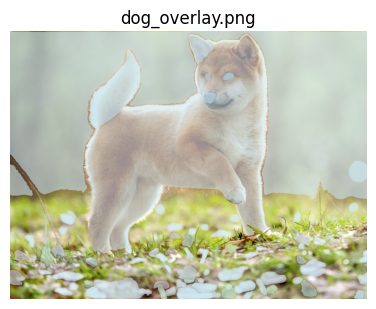

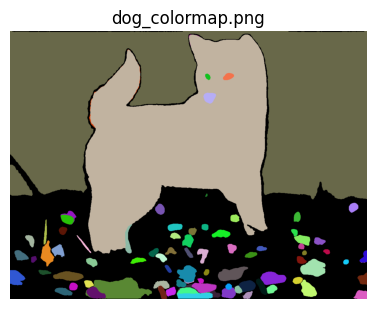

In [13]:
overlays = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*_overlay.png")))
n_show = min(6, len(overlays))
plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.subplot(2, 3, i + 1)
    im = Image.open(overlays[i]).convert("RGB")
    plt.imshow(im)
    plt.title(os.path.basename(overlays[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

# Look for all saved *_colormap.png files
colormaps = sorted(glob.glob(os.path.join(OUTPUT_DIR, "*_colormap.png")))

n_show = min(6, len(colormaps))
plt.figure(figsize=(12, 6))
for i in range(n_show):
    plt.subplot(2, 3, i + 1)
    im = Image.open(colormaps[i]).convert("RGB")
    plt.imshow(im)
    plt.title(os.path.basename(colormaps[i]))
    plt.axis("off")

plt.tight_layout()
plt.show()

## 9. Final Report
We print the configuration overview similar to previous labs (batch size, device, mode).


In [14]:
print("=== Inference Configuration ===")
print(f"SAM variant     : {cfg.sam_variant}")
print(f"Checkpoint file : {cfg.sam_ckpt_name}")
print(f"Prompt mode     : {cfg.prompt_mode}")
print(f"Batch size      : {cfg.batch_size}")
print(f"Image max side  : {cfg.img_size_limit}")
print(f"Device          : {cfg.device}")
print("\nArtifacts saved in:", OUTPUT_DIR)
print(" - log.txt")
print(" - sam_inference_report.csv")
print(" - *_overlay.png and *_mask_XXX.png files")

=== Inference Configuration ===
SAM variant     : vit_b
Checkpoint file : sam_vit_b.pth
Prompt mode     : auto
Batch size      : 8
Image max side  : 2048
Device          : cuda

Artifacts saved in: /home/aup/data/sam_outputs
 - log.txt
 - sam_inference_report.csv
 - *_overlay.png and *_mask_XXX.png files
